In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('prep_karl_marx_str.csv')

In [27]:
df

,timestamp,value
0,2022-06-22 15:00:00,6.624211
1,2022-06-22 16:00:00,11.142609
2,2022-06-22 17:00:00,16.702917
3,2022-06-22 18:00:00,9.950435
4,2022-06-22 19:00:00,13.147083
...,...,...
17677,2024-06-28 04:00:00,31.445417
17678,2024-06-28 05:00:00,31.499583
17679,2024-06-28 06:00:00,25.917500
17680,2024-06-28 07:00:00,18.865000


In [28]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

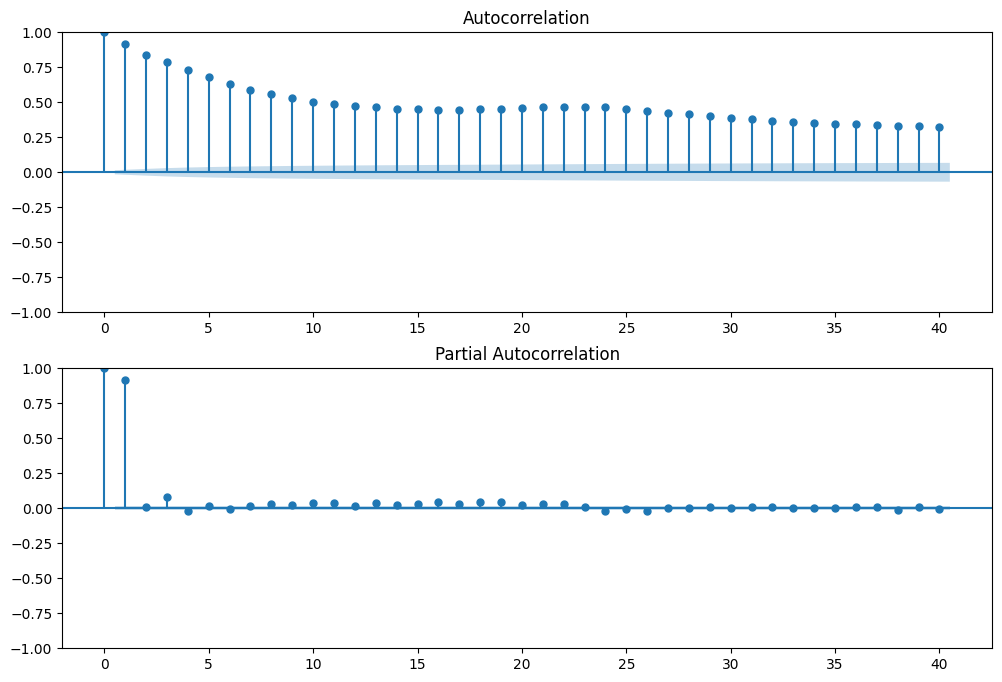

In [29]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot Autocorrelation and Partial Autocorrelation Functions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['value'], lags=40, ax=ax1)  # ACF plot
plot_pacf(df['value'], lags=40, ax=ax2)  # PACF plot

plt.show()


In [30]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(df['value'])

# Create a readable output of the test results
adf_output = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Lags Used': adf_result[2],
    'Number of Observations Used': adf_result[3],
    'Critical Values': adf_result[4],
    'Maximized Information Criterion': adf_result[5]
}

adf_output


{'Test Statistic': -10.35853718395394,
 'p-value': 2.4304968514457455e-18,
 'Lags Used': 44,
 'Number of Observations Used': 17637,
 'Critical Values': {'1%': -3.430720825650877,
  '5%': -2.8617038906952557,
  '10%': -2.566857234748962},
 'Maximized Information Criterion': 135825.74665205565}

Nullhypothese verwerfen, die Zetreihe ist also stationär.

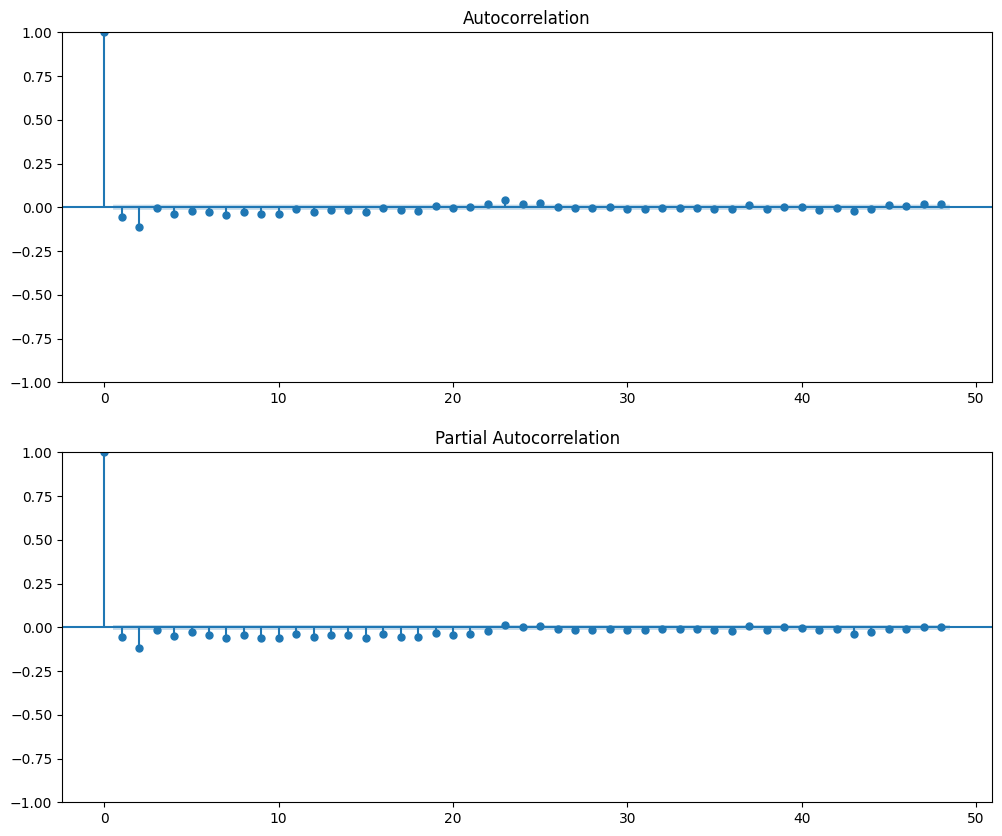

In [31]:
# Differencing the data
df_differenced = df['value'].diff().dropna()

# Plot Autocorrelation and Partial Autocorrelation Functions for differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_differenced, lags=48, ax=ax1)  # ACF plot for differenced data
plot_pacf(df_differenced, lags=48, ax=ax2)  # PACF plot for differenced data

plt.show()


In [32]:
# Perform Augmented Dickey-Fuller test on the differenced data to check for stationarity
adf_result_differenced = adfuller(df_differenced)

# Create a readable output of the test results for the differenced data
adf_output_differenced = {
    'Test Statistic': adf_result_differenced[0],
    'p-value': adf_result_differenced[1],
    'Lags Used': adf_result_differenced[2],
    'Number of Observations Used': adf_result_differenced[3],
    'Critical Values': adf_result_differenced[4],
    'Maximized Information Criterion': adf_result_differenced[5]
}

adf_output_differenced


{'Test Statistic': -28.18557356919316,
 'p-value': 0.0,
 'Lags Used': 43,
 'Number of Observations Used': 17637,
 'Critical Values': {'1%': -3.430720825650877,
  '5%': -2.8617038906952557,
  '10%': -2.566857234748962},
 'Maximized Information Criterion': 135924.29639025236}

In [33]:
import pandas as pd

# Angenommen, df ist Ihr DataFrame und 'date' ist der Index im Datumsformat
df.sort_index(inplace=True)  # Stellen Sie sicher, dass die Daten nach Datum sortiert sind

# Berechnen Sie den Index, der das Ende des Trainingsdatensatzes markiert
train_size = int(len(df) * 0.8)
train_set = df.iloc[:train_size]
test_set = df.iloc[train_size:]

# Beispiel: Zugriff auf Trainings- und Testdaten
print(train_set.head())
print(test_set.head())


                         value
timestamp                     
2022-06-22 15:00:00   6.624211
2022-06-22 16:00:00  11.142609
2022-06-22 17:00:00  16.702917
2022-06-22 18:00:00   9.950435
2022-06-22 19:00:00  13.147083
                         value
timestamp                     
2024-02-02 00:00:00  21.632500
2024-02-02 01:00:00  21.483750
2024-02-02 02:00:00  22.340417
2024-02-02 03:00:00  24.557600
2024-02-02 04:00:00  23.516250


In [ ]:
from statsmodels.tsa.stattools import acf
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train['value'], order=(2, 1, 2))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

p = q = range(0, 4)
d = 1

train_set.index.freq = 'h'

model_results_original = []

# Iterate over all combinations of p, d, and q to fit ARIMA model and compute AIC for original data
for p_value in p:
    for q_value in q:
        try:
            # Fit ARIMA model
            model = ARIMA(train_set['value'], order=(p_value, d, q_value))
            model_fit = model.fit()
            # Store results
            model_results_original.append((p_value, d, q_value, model_fit.aic))
        except Exception as e:
            print(f"Failed to fit ARIMA({p_value},{d},{q_value}): {e}")

# Convert results to a DataFrame for better visualization
model_results_original_df = pd.DataFrame(model_results_original, columns=['p', 'd', 'q', 'AIC'])

# Find the model with the lowest AIC
best_model_original = model_results_original_df.loc[model_results_original_df['AIC'].idxmin()]

model_results_original_df, best_model_original


C:\Users\Markus\anaconda3\envs\S4\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(    p  d  q            AIC
 0   0  1  0  112165.831679
 1   0  1  1  112079.523015
 2   0  1  2  111813.714262
 3   0  1  3  111808.454916
 4   1  1  0  112102.504084
 5   1  1  1  111375.981664
 6   1  1  2  111377.978789
 7   1  1  3  111301.379350
 8   2  1  0  111858.130732
 9   2  1  1  111377.979331
 10  2  1  2  111340.128261
 11  2  1  3  111288.489271
 12  3  1  0  111853.914154
 13  3  1  1  111300.648820
 14  3  1  2  111287.869559
 15  3  1  3  111289.902588,
 p           3.000000
 d           1.000000
 q           2.000000
 AIC    111287.869559
 Name: 14, dtype: float64)

In [15]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                14145
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -55637.951
Date:                Fri, 28 Jun 2024   AIC                         111289.903
Time:                        10:58:14   BIC                         111342.802
Sample:                    06-22-2022   HQIC                        111307.504
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4570      0.046      9.862      0.000       0.366       0.548
ar.L2          0.2929      0.042      6.931      0.000       0.210       0.376
ar.L3          0.0757      0.051      1.471      0.141      -0.025       0.176
ma.L1         -0.5757      0.047    -12.309      0.000      -0.667      -0.484
ma.L2         -0.4078      0.042     -9.676      0.000      -0.490      -0.325
ma.L3          0.0008      0.061      0.013      0.990      -0.118       0.120
sigma2       152.8146      0.128   1189.724      0.000     152.563     153.066
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         215356907.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             9.71
Prob(H) (two-sided):                  0.00   Kurtosis:                       607.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
test_set

<Axes: xlabel='timestamp'>

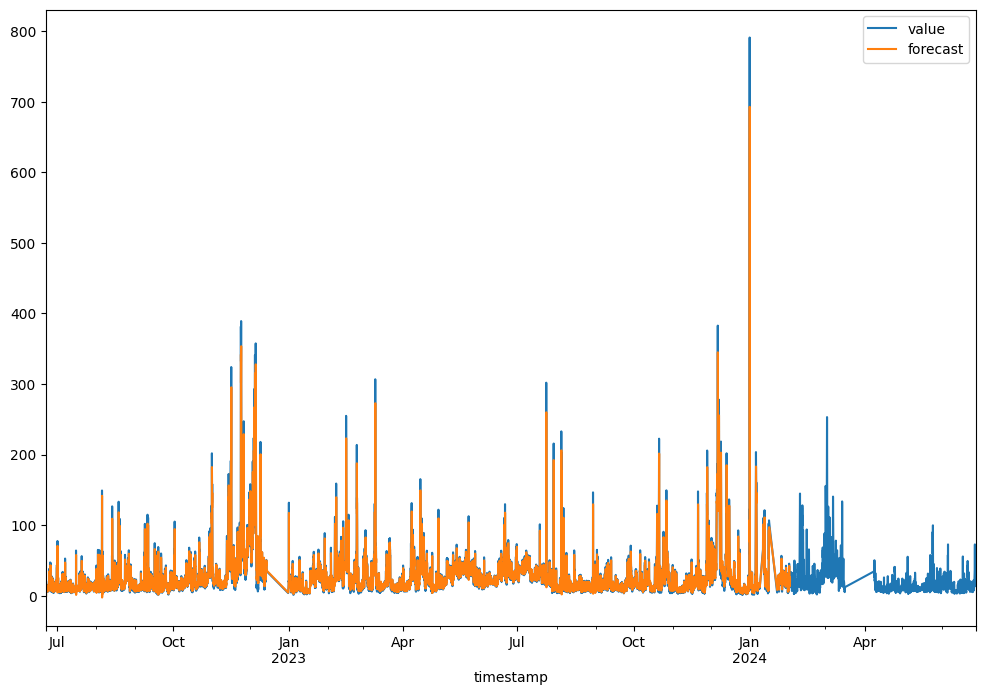

In [19]:
df['forecast']=model_fit.predict()
df[['value','forecast']].plot(figsize=(12,8))

# Speichern

In [21]:
import pickle

# Fit the best ARIMA model
best_arima_model = ARIMA(df['value'], order=(3, 1, 2))
best_arima_model_fit = best_arima_model.fit()

# Save the model to a file
model_filename = 'karl_marx_arima_312_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_arima_model_fit, file)

model_filename


C:\Users\Markus\anaconda3\envs\S4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Markus\anaconda3\envs\S4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Markus\anaconda3\envs\S4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


'karl_marx_arima_312_model.pkl'

In [35]:
import pickle

# Pfad zur gespeicherten Modell-Datei
model_filename = 'karl_marx_arima_312_model.pkl'

# Laden des Modells
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Anzahl der Zeitschritte, die vorhergesagt werden sollen
num_forecast_steps = 24

# Vorhersage machen
forecast = loaded_model.forecast(steps=num_forecast_steps)

print("Die Vorhersage für die nächsten", num_forecast_steps, "Zeitpunkte ist:", forecast)


Die Vorhersage für die nächsten 24 Zeitpunkte ist: 2024-06-29 11:00:00    12.027708
2024-06-29 12:00:00    12.560351
2024-06-29 13:00:00    12.768209
2024-06-29 14:00:00    13.089481
2024-06-29 15:00:00    13.328226
2024-06-29 16:00:00    13.550692
2024-06-29 17:00:00    13.745068
2024-06-29 18:00:00    13.917112
2024-06-29 19:00:00    14.069190
2024-06-29 20:00:00    14.203562
2024-06-29 21:00:00    14.322329
2024-06-29 22:00:00    14.427289
2024-06-29 23:00:00    14.520051
2024-06-30 00:00:00    14.602031
2024-06-30 01:00:00    14.674483
2024-06-30 02:00:00    14.738515
2024-06-30 03:00:00    14.795105
2024-06-30 04:00:00    14.845118
2024-06-30 05:00:00    14.889317
2024-06-30 06:00:00    14.928380
2024-06-30 07:00:00    14.962903
2024-06-30 08:00:00    14.993414
2024-06-30 09:00:00    15.020378
2024-06-30 10:00:00    15.044208
Freq: h, Name: predicted_mean, dtype: float64
